# Exploring Yelp Toronto Businesses and Their Reviews in Relation to Nearby Attractions

### Naura Izzah Taufiq (1009713669)

## A. Introduction

Tourism plays a major role in shaping the economy of Toronto, Canada’s largest city and a popular tourist destination. Understanding how proximity to attractions influences business success can offer valuable insights for business owners, urban planners, and tourism boards. This study investigates whether businesses near Toronto's tourist attractions perform better in ratings and review volume compared to those farther away. It also examines whether certain attractions are linked to higher ratings and more positive reviews. Additionally, the project explores how review sentiment differs between businesses located near and far from popular attractions, along with analyzing Toronto businesses' overall review sentiment.

This analysis uses three datasets. The first is the Places of Interest and Toronto Attractions dataset from Toronto Open Data, sourced from the Toronto Tourist Information Centre. The other two are Yelp datasets from Kaggle, originally from Yelp Open Dataset. These include Yelp Business data (business details like name, location, rating, review counts, categories) and Yelp Review data (filtered to only include Toronto business reviews).

By merging these datasets and applying data analysis techniques, this study aims to explore the relationship between business performance and proximity to attractions, while also analyzing general sentiment trends in Toronto business reviews.

In [5]:
#| include: false

# ALL IMPORTS
import logging
logging.getLogger().setLevel(logging.ERROR)  # Suppress info/warning messages
import warnings
warnings.filterwarnings("ignore")
import requests
import pandas as pd
import numpy as np
import time
import random
import ast
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from collections import Counter

nltk.download('punkt')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /opt/conda/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /opt/conda/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /opt/conda/nltk_data...


True

## B. Methods

### B.1 Loading and Merging Datasets

The datasets for this project were obtained from the Toronto Open Data API and Kaggle (Yelp Open Data subsets). The Toronto Open Data API was accessed via the CKAN interface to retrieve the “Places of Interest and Toronto Attractions” dataset, which provides information such as attraction name, category, and geographical coordinates as well as some other details like contacts, websites and a short bio. The Yelp Business and Review datasets were downloaded then read. The Business dataset provides information about business names, locations and coordinates, ratings, categories, and review counts. Finally, the Review dataset offers textual reviews, ratings, and dates as well as the user and business information.

In [6]:
#| include: FALSE
########################## API, LOAD DATASETS, BUILDING DATAFRAMES, MERGING #############################

### THESE CODES ARE RETRIEVED FROM TORONTO OPEN DATA DOCUMENTATION ###

base_url = "https://ckan0.cf.opendata.inter.prod-toronto.ca"
package_id = "places-of-interest-and-toronto-attractions"
url = base_url + "/api/3/action/package_show"
params = {"id": package_id}
package = requests.get(url, params=params).json()

if not package["success"]:
    raise Exception(f"Failed to fetch metadata for package: {package_id}")

# Find the first datastore_active resource (assume it contains the full dataset)
for resource in package["result"]["resources"]:
    if resource["datastore_active"]:
        # Fetch all records in CSV format
        url = base_url + "/datastore/dump/" + resource["id"]
        response = requests.get(url)
        
        # Save the CSV data to a file
        with open("toronto_attractions.csv", "w") as file:
            file.write(response.text)
        print("Dataset saved to toronto_attractions.csv")
        break
else:
    print("No datastore_active resource found in the package.")

Dataset saved to toronto_attractions.csv


In [7]:
#| include: FALSE
### READ 3 DATASETS : TORONTO_ATTRACTIONS.CSV, YELP_BUSINESS.CSV, YELP_REVIEW.CSV ###

attractions_df = pd.read_csv('toronto_attractions.csv')
attractions_df.head()

,_id,ADDRESS_INFO,NAME,CATEGORY,PHONE,EMAIL,WEBSITE,GEOID,RECEIVED_DATE,ADDRESS_POINT_ID,...,HI_NUM,HI_NUM_SUF,LINEAR_NAME_ID,WARD,WARD_2003,WARD_2021,MI_PRINX,ATTRACTION,MAP_ACCESS,geometry
0,1,NaN,299 Queen Street West,Landmark,416-384-6104,NaN,https://www.much.com/,3948802.0,NaN,3948802.0,...,NaN,NaN,4238.0,Spadina-Fort York,20.0,10.0,3079761.0,A monumental building that was once dedicated ...,Y,"{""type"": ""Point"", ""coordinates"": [-79.39044, 4..."
1,2,NaN,Aga Khan Museum,Museum,416-646-4677,NaN,https://www.agakhanmuseum.org/,10142948.0,NaN,10142948.0,...,NaN,NaN,7128.0,Don Valley East,26.0,16.0,4094277.0,"Dedicated to sharing the artistic, intellectua...",Y,"{""type"": ""Point"", ""coordinates"": [-79.33223, 4..."
2,3,NaN,Al Green Theatre (at the Miles Nadal Jewish Co...,Performing Arts,416-924-6211,NaN,http://www.algreentheatre.ca/,8418224.0,NaN,8418224.0,...,NaN,NaN,4426.0,University-Rosedale,20.0,11.0,1951177.0,The Al Green Theatre is used for social and c...,N,"{""type"": ""Point"", ""coordinates"": [-79.40395, 4..."
3,4,NaN,Alexander Muir Memorial Gardens,Nature/ Park,416-396-7378,NaN,https://www.toronto.ca/data/parks/prd/faciliti...,10154587.0,NaN,10154587.0,...,NaN,NaN,4733.0,Don Valley West,25.0,15.0,4217141.0,Named after the famous composer Alexander Muir...,Y,"{""type"": ""Point"", ""coordinates"": [-79.4012, 43..."
4,5,NaN,Allan Gardens,Nature/ Park,416-392-7288,NaN,https://www.toronto.ca/explore-enjoy/parks-rec...,12387690.0,NaN,12387690.0,...,NaN,NaN,3695.0,Toronto Centre,27.0,13.0,3358221.0,Allan Gardens is a park and indoor botanical g...,Y,"{""type"": ""Point"", ""coordinates"": [-79.37458, 4..."


In [8]:
#| include: FALSE

business_df = pd.read_csv('yelp_business.csv')
business_df.head()

,business_id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
0,FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design""",NaN,"""4855 E Warner Rd, Ste B9""",Ahwatukee,AZ,85044,33.330690,-111.978599,4.0,22,1,Dentists;General Dentistry;Health & Medical;Or...
1,He-G7vWjzVUysIKrfNbPUQ,"""Stephen Szabo Salon""",NaN,"""3101 Washington Rd""",McMurray,PA,15317,40.291685,-80.104900,3.0,11,1,Hair Stylists;Hair Salons;Men's Hair Salons;Bl...
2,KQPW8lFf1y5BT2MxiSZ3QA,"""Western Motor Vehicle""",NaN,"""6025 N 27th Ave, Ste 1""",Phoenix,AZ,85017,33.524903,-112.115310,1.5,18,1,Departments of Motor Vehicles;Public Services ...
3,8DShNS-LuFqpEWIp0HxijA,"""Sports Authority""",NaN,"""5000 Arizona Mills Cr, Ste 435""",Tempe,AZ,85282,33.383147,-111.964725,3.0,9,0,Sporting Goods;Shopping
4,PfOCPjBrlQAnz__NXj9h_w,"""Brick House Tavern + Tap""",NaN,"""581 Howe Ave""",Cuyahoga Falls,OH,44221,41.119535,-81.475690,3.5,116,1,American (New);Nightlife;Bars;Sandwiches;Ameri...


In [9]:
#| include: FALSE

reviews_df = pd.read_csv('yelp_review_ny_tor.csv')
reviews_df.head()

,review_id,user_id,business_id,stars,date,text,useful,funny,cool
0,ymAUG8DZfQcFTBSOiaNN4w,u0LXt3Uea_GidxRW1xcsfg,9_CGhHMz8698M9-PkVf0CQ,4,2012-05-11,Who would have guess that you would be able to...,0,0,2
1,8UIishPUD92hXtScSga_gw,u0LXt3Uea_GidxRW1xcsfg,gkCorLgPyQLsptTHalL61g,4,2015-10-27,Always drove past this coffee house and wonder...,1,0,0
2,w41ZS9shepfO3uEyhXEWuQ,u0LXt3Uea_GidxRW1xcsfg,5r6-G9C4YLbC7Ziz57l3rQ,3,2013-02-09,"Not bad!! Love that there is a gluten-free, ve...",1,0,0
3,WF_QTN3p-thD74hqpp2j-Q,u0LXt3Uea_GidxRW1xcsfg,fDF_o2JPU8BR1Gya--jRIA,5,2016-04-06,Love this place!\n\nPeggy is great with dogs a...,3,0,0
4,PIsUSmvaUWB00qv5KTF1xA,u0LXt3Uea_GidxRW1xcsfg,z8oIoCT1cXz7gZP5GeU5OA,4,2013-05-01,This is currently my parents new favourite res...,1,0,0


Before proceeding with creating new variables and merging the datasets, it is crucial to address duplicate entries within each dataset to prevent inflation (double duplicates) of the merged dataset. For the attractions dataset, duplicates were identified by comparing entries with the same name. For the business dataset, duplicates were detected by examining rows with matching business names, addresses, neighborhoods, and postal codes since a chain will have the same names but diffent locations. Finally, for the reviews dataset, duplicates were identified by comparing user IDs, review texts, business IDs, and ratings as one user may write the same texts for other businesses.

In [10]:
#| include: FALSE
### IMPORTANT : Before I do anything with these 3 dataframes, I want to clean up duplicates first so we don't
### end up with multiple duplicates. This "partial data cleaning" is extremely important to do beforehand because
### I will merge some datas together and this could create duplicates of duplicates.

### ATTRACTIONS_DF
# Check for duplicate rows
duplicate_att = attractions_df[attractions_df.duplicated(subset=['NAME'], keep=False)]

# Display duplicate rows (if any)
print("Duplicate Rows Attractions:")
print(duplicate_att)

### BUSINESS_DF
duplicate_business = business_df[business_df.duplicated(subset=['name', 'address', 'neighborhood', 'postal_code'], keep=False)]
print("Duplicate Rows Business:")
print(duplicate_business)

### REVIEWS_DF
duplicate_reviews = reviews_df[reviews_df.duplicated(subset=['user_id', 'text', 'business_id', 'stars'], keep=False)]
print("Duplicate Rows Reviews:")
print(duplicate_reviews)

Duplicate Rows Attractions:
Empty DataFrame
Columns: [_id, ADDRESS_INFO, NAME, CATEGORY, PHONE, EMAIL, WEBSITE, GEOID, RECEIVED_DATE, ADDRESS_POINT_ID, ADDRESS_NUMBER, LINEAR_NAME_FULL, ADDRESS_FULL, POSTAL_CODE, MUNICIPALITY, CITY, PLACE_NAME, GENERAL_USE_CODE, CENTRELINE, LO_NUM, LO_NUM_SUF, HI_NUM, HI_NUM_SUF, LINEAR_NAME_ID, WARD, WARD_2003, WARD_2021, MI_PRINX, ATTRACTION, MAP_ACCESS, geometry]
Index: []

[0 rows x 31 columns]
Duplicate Rows Business:
                   business_id                          name neighborhood  \
377     kFuFm8NmxyVkj4xVWO1ugw    "Cora Breakfast and Lunch"          NaN   
538     AfL8Ds7ex73tfVbq3EFWKg                  "Baja Fresh"     Westside   
575     f4mh1Y0rnvbJRfQ3jPkqzQ        "AMC Concord Mills 24"          NaN   
596     hTzcHtk4-0QJnFUbkKpd5Q                 "Citi Trends"          NaN   
824     YT9zQ9dL4sFZg0Y8IPK6CQ               "Souper Market"          NaN   
...                        ...                           ...          ...   


The most significant issue was found in the business dataset, where 356 duplicate rows were identified. Upon observation, it seemed like this might be caused by update in business information (perhaps the opening of a new renovation/closing of the business, or updating the review count). The most significant issue was 356 duplicate rows in the business dataset, likely due to updates in business information. We retained the most recent data based on whether the business is open or has the highest review count.
This reduced the total entries from 174,567 to 174,387 (note that this is still not exclusive to Toronto only).

In [11]:
#| include: FALSE

print("Shape before removing duplicates:", business_df.shape)

### clean business_df duplicates based on open, and more review count
# Sort the DataFrame
business_df_sorted = business_df.sort_values(
    by=['is_open', 'review_count'],  # Sort by is_open first, then review_count
    ascending=[False, False]         # Descending order for both
)

# Drop duplicates, keeping the first occurrence
business_df_cleaned = business_df_sorted.drop_duplicates(
    subset=['name', 'neighborhood', 'address', 'postal_code'],  # Columns to identify duplicates
    keep='first'  # Keep the first occurrence (latest or most active)
)

# Verify duplicates are removed
print("Shape after removing duplicates:", business_df_cleaned.shape)

Shape before removing duplicates: (174567, 13)
Shape after removing duplicates: (174387, 13)


WWe filtered Yelp Business data to only include Toronto businesses and merged it with the attractions dataset by finding the nearest attraction for each business. Missing values were first addressed by removing entries lacking coordinates information since it was pertinent for this step. Then, to identify the nearest tourist attraction for each business, we constructed a KDTree spatial index using the attraction coordinates. Each business was linked to its nearest attraction, and the distance between them was calculated. This result in a dataset that contains Toronto business details and the nearest attraction information for that business (id, name, category and its distance from the business). 

In [12]:
#| include: FALSE

### CREATING TORONTO BUSINESS DF WITH NEAREST ATTRACTION INFO ###

toronto_business_df = business_df_cleaned[business_df_cleaned['city'] == 'Toronto']

# Extract latitude and longitude from attractions_df
attractions_df['coordinates'] = attractions_df['geometry'].apply(
    lambda x: tuple(eval(x)['coordinates'])
)
attractions_df['longitude'] = attractions_df['coordinates'].apply(lambda x: x[0])
attractions_df['latitude'] = attractions_df['coordinates'].apply(lambda x: x[1])

# Drop rows with NaN or inf 
toronto_business_df = toronto_business_df.dropna(subset=['latitude', 'longitude'])
toronto_business_df = toronto_business_df[~toronto_business_df[['latitude', 'longitude']].isin([np.nan, np.inf, -np.inf]).any(axis=1)]
attractions_df = attractions_df.dropna(subset=['latitude', 'longitude'])
attractions_df = attractions_df[~attractions_df[['latitude', 'longitude']].isin([np.nan, np.inf, -np.inf]).any(axis=1)]

# Convert business and attraction coordinates into lists of (longitude, latitude) tuples
business_coords = toronto_business_df[['longitude', 'latitude']].values
attraction_coords = attractions_df[['longitude', 'latitude']].values

# Build a KDTree for attractions
tree = cKDTree(attraction_coords)

# Find the nearest attraction for each business
# k=1 since we only want the nearEST attraction
distances, indices = tree.query(business_coords, k=1)

toronto_business_df['nearest_attraction_id'] = attractions_df.iloc[indices]['_id'].values
toronto_business_df['nearest_attraction_name'] = attractions_df.iloc[indices]['NAME'].values
toronto_business_df['nearest_attraction_category'] = attractions_df.iloc[indices]['CATEGORY'].values
toronto_business_df['distance_km'] = distances * 111  # Convert degrees to kilometers (approximate)

business_tor = toronto_business_df.copy()
print(business_tor.head())

                   business_id                            name  \
107580  r_BrIgzYcwo1NAuG9dLbpg     "Pai Northern Thai Kitchen"   
158973  aLcFhMe6DDJ430zelCpd2A                 "Khao San Road"   
9526    RtUvSWO_UZ8V3Wpj0n077w        "KINKA IZAKAYA ORIGINAL"   
131553  N93EYZy9R0sdlEvubu94ig                  "Banh Mi Boys"   
80828   iGEvDk6hsizigmXhDKs2Vg  "Seven Lives Tacos Y Mariscos"   

                  neighborhood                 address     city state  \
107580  Entertainment District      "18 Duncan Street"  Toronto    ON   
158973  Entertainment District       "11 Charlotte St"  Toronto    ON   
9526             Downtown Core         "398 Church St"  Toronto    ON   
131553       Queen Street West    "392 Queen Street W"  Toronto    ON   
80828        Kensington Market  "69 Kensington Avenue"  Toronto    ON   

       postal_code   latitude  longitude  stars  review_count  is_open  \
107580     M5H 3G8  43.647866 -79.388642    4.5          1494        1   
158973     M5V 2

We also merged the Toronto business data with the reviews data such that now we have more details on the business that the user reviewed upon. That concluded this loading and merging dataset step (primarily using pandas), and we are ready to do exploratory data analysis.

In [13]:
#| include: FALSE

### MERGING TORONTO BUSINESS DF AND TORONTO REVIEWS DF ###

reviews_tor = pd.merge(
    reviews_df,  
    business_df[['business_id', 'name', 'categories']],  
    on='business_id',  
    how='left'  
)

print(reviews_tor.head())

                review_id                 user_id             business_id  \
0  ymAUG8DZfQcFTBSOiaNN4w  u0LXt3Uea_GidxRW1xcsfg  9_CGhHMz8698M9-PkVf0CQ   
1  8UIishPUD92hXtScSga_gw  u0LXt3Uea_GidxRW1xcsfg  gkCorLgPyQLsptTHalL61g   
2  w41ZS9shepfO3uEyhXEWuQ  u0LXt3Uea_GidxRW1xcsfg  5r6-G9C4YLbC7Ziz57l3rQ   
3  WF_QTN3p-thD74hqpp2j-Q  u0LXt3Uea_GidxRW1xcsfg  fDF_o2JPU8BR1Gya--jRIA   
4  PIsUSmvaUWB00qv5KTF1xA  u0LXt3Uea_GidxRW1xcsfg  z8oIoCT1cXz7gZP5GeU5OA   

   stars        date                                               text  \
0      4  2012-05-11  Who would have guess that you would be able to...   
1      4  2015-10-27  Always drove past this coffee house and wonder...   
2      3  2013-02-09  Not bad!! Love that there is a gluten-free, ve...   
3      5  2016-04-06  Love this place!\n\nPeggy is great with dogs a...   
4      4  2013-05-01  This is currently my parents new favourite res...   

   useful  funny  cool                                        name  \
0       0      0

### B.2 Data Wrangling and Exploratory Data Analysis

We primarily used Pandas for data wrangling. We first observed the two datasets (Toronto business data with attractions information, Toronto reviews data with business details) by its dimensions and columns. The business data has 17,199 observations with 17 variables: business ID, name of the business, its neighborhood, its full address, city (Toronto), state (ON), postal code, latitude, longitude, average ratings, review count (total number of reviews), is_open (indicating whether the business is open or not), categories (which categories do the business offer; may be restaurant/cafe and its cuisine_type, the services, etc.) alongside the nearest attraction details (IDs, name, category, and the distance to that business). Most variables are character/string object, except some numerical variables like coordinates (continuous), review counts (discrete), attraction IDs (discrete), is_open (binary number) and attraction distance in kilometer (continuous).

The reviews Data Shape has 430,985 reviews and 11 variables: review IDs, user ID that wrote that review, business ID and business name of the intended review, rating, date of the review, the review text, reactions (number of upvote for useful/funny/cool) and the categories of the business. Again, most variables are character/string object, except some numerical variables like rating (discrete from 1-5) and reactions. Note that we also decided to rename some variables for readability.

In [14]:
#| include: FALSE
########################## DATA CLEANING, WRANGLING, EDA #############################

# Check dimensions
print("Business Toronto Data Shape:", business_tor.shape)
print("Reviews Toronto Data Shape:", reviews_tor.shape)

# headers
print("\nBusiness Toronto Data Head:")
print(business_tor.head())
print("\nReviews Toronto Data Head:")
print(reviews_tor.head())

# footers
print("\nBusiness Toronto Data Tail:")
print(business_tor.tail())
print("\nReviews Toronto Data Tail:")
print(reviews_tor.tail())

Business Toronto Data Shape: (17199, 17)
Reviews Toronto Data Shape: (430985, 11)

Business Toronto Data Head:
                   business_id                            name  \
107580  r_BrIgzYcwo1NAuG9dLbpg     "Pai Northern Thai Kitchen"   
158973  aLcFhMe6DDJ430zelCpd2A                 "Khao San Road"   
9526    RtUvSWO_UZ8V3Wpj0n077w        "KINKA IZAKAYA ORIGINAL"   
131553  N93EYZy9R0sdlEvubu94ig                  "Banh Mi Boys"   
80828   iGEvDk6hsizigmXhDKs2Vg  "Seven Lives Tacos Y Mariscos"   

                  neighborhood                 address     city state  \
107580  Entertainment District      "18 Duncan Street"  Toronto    ON   
158973  Entertainment District       "11 Charlotte St"  Toronto    ON   
9526             Downtown Core         "398 Church St"  Toronto    ON   
131553       Queen Street West    "392 Queen Street W"  Toronto    ON   
80828        Kensington Market  "69 Kensington Avenue"  Toronto    ON   

       postal_code   latitude  longitude  stars  revi

In [15]:
#| include: FALSE

# Check variable types
print("\nBusiness Data Types:")
print(business_tor.dtypes)

print("\nReviews Data Types:")
print(reviews_tor.dtypes)


Business Data Types:
business_id                     object
name                            object
neighborhood                    object
address                         object
city                            object
state                           object
postal_code                     object
latitude                       float64
longitude                      float64
stars                          float64
review_count                     int64
is_open                          int64
categories                      object
nearest_attraction_id            int64
nearest_attraction_name         object
nearest_attraction_category     object
distance_km                    float64
dtype: object

Reviews Data Types:
review_id      object
user_id        object
business_id    object
stars           int64
date           object
text           object
useful          int64
funny           int64
cool            int64
name           object
categories     object
dtype: object


In [16]:
#| include: FALSE

# change column names for easy-understanding

business_tor = business_tor.rename(columns={
    'stars': 'avg_rating'
})

reviews_tor = reviews_tor.rename(columns={
    'stars': 'rating',
    'text': 'review_text',
    'name': 'business_name'
})

print("Business Toronto Data Columns:", business_tor.columns)
print("Reviews Toronto Data Columns:", reviews_tor.columns)

Business Toronto Data Columns: Index(['business_id', 'name', 'neighborhood', 'address', 'city', 'state',
       'postal_code', 'latitude', 'longitude', 'avg_rating', 'review_count',
       'is_open', 'categories', 'nearest_attraction_id',
       'nearest_attraction_name', 'nearest_attraction_category',
       'distance_km'],
      dtype='object')
Reviews Toronto Data Columns: Index(['review_id', 'user_id', 'business_id', 'rating', 'date', 'review_text',
       'useful', 'funny', 'cool', 'business_name', 'categories'],
      dtype='object')


Upon observing the summary of the datas, we found some missing values for some columns like business neighborhood and postal code that we decided to ignore since it did not affect much of our later analysis. However, we realized there were some variables that needed further check.

1. Geographical filtering was applied to validate the coordinates, ensuring that businesses were located within Toronto’s boundaries (latitude: 43.5-43.9, longitude: -79.6-79.2). We decided to remove anything outside since they were no longer in Toronto city.

2. There were two unique state so corrections were made for state code errors ('AB' to 'ON') to maintain consistency. It turned out to be a mistake since the address for that business was in Toronto.

3. There were duplicates in the review texts. We decided to perform extensive cleaning. First, we identified several texts occurring multiple times. To further investigate, we checked for exact duplicates where the same review text, business ID, and review ID were repeated. No exact duplicates were found, but some reviews were associated with multiple user IDs. Thus, we sorted reviews by date and retained only the oldest instance of each duplicated review text, assuming the earliest review was the original. We also removed cases where the same review text was associated with multiple users. Note that we did not remove the duplicated text for different business IDs as the rationale would be that it is possible for one user to use the same review for another business. 

This process reduced the dataset from 430,985 to 430,906 entries, ensuring that the dataset accurately reflects genuine customer feedback for reliable analysis. 

In [17]:
#| include: FALSE

# look at summary

# Business Data
print("\nBusiness Data Summary:")
print(business_tor.describe(include='all'))
print("\nBusiness Data NA Count:")
print(business_tor.isnull().sum())

# Reviews Data
print("\nReviews Data Summary:")
print(reviews_tor.describe(include='all'))
print("\nReviews Data NA Count:")
print(reviews_tor.isnull().sum())


Business Data Summary:
                   business_id         name   neighborhood address     city  \
count                    17199        17199          14058   17199    17199   
unique                   17199        14459             80   13722        1   
top     r_BrIgzYcwo1NAuG9dLbpg  "Starbucks"  Downtown Core      ""  Toronto   
freq                         1          146           1630     255    17199   
mean                       NaN          NaN            NaN     NaN      NaN   
std                        NaN          NaN            NaN     NaN      NaN   
min                        NaN          NaN            NaN     NaN      NaN   
25%                        NaN          NaN            NaN     NaN      NaN   
50%                        NaN          NaN            NaN     NaN      NaN   
75%                        NaN          NaN            NaN     NaN      NaN   
max                        NaN          NaN            NaN     NaN      NaN   

        state postal_code  

In [18]:
#| include: FALSE

# look more for lat - lon to make sure it's Toronto

# ranges for Toronto
valid_lat_range = (43.5, 43.9)
valid_lon_range = (-79.6, -79.2)

# Identify rows with invalid latitude or longitude
invalid_lat = business_tor[(business_tor['latitude'] < valid_lat_range[0]) | (business_tor['latitude'] > valid_lat_range[1])]
invalid_lon = business_tor[(business_tor['longitude'] < valid_lon_range[0]) | (business_tor['longitude'] > valid_lon_range[1])]

print("Rows with invalid latitude:")
print(invalid_lat[['business_id', 'latitude', 'longitude']])

print("\nRows with invalid longitude:")
print(invalid_lon[['business_id', 'latitude', 'longitude']])

# Filter out rows with invalid latitude or longitude
business_tor_cleaned = business_tor[
    (business_tor['latitude'].between(*valid_lat_range)) &
    (business_tor['longitude'].between(*valid_lon_range))
]

print("Shape before cleaning:", business_tor.shape)
print("Shape after cleaning:", business_tor_cleaned.shape)

print(business_tor_cleaned[['latitude', 'longitude']].describe())

Rows with invalid latitude:
                   business_id   latitude  longitude
118538  sDqK7RBNIOAE4k7MFVpPFQ  -9.095137 -51.833829
18212   6y8Ck9goltpRRZeyq1nb-A  45.028731 -76.364179
151324  B1lkyK4_6mAfOtuC-qJAnA  43.301967 -80.623297

Rows with invalid longitude:
                   business_id   latitude  longitude
92462   VZbKJBbcxCOvuZyuEOojsg  43.817699 -79.185903
160893  av8IudUXe91QRrUQvIXhDA  43.799614 -79.194790
66353   jMArT7rSpW3Be8CaI6wo-w  43.789967 -79.196561
157951  aCNiO3KPX-nB2vdSRFjxdQ  43.648382 -79.604713
132946  v3gSujyy-PB8q9pSqot2Rg  43.686504 -79.619853
...                        ...        ...        ...
35794   gJoI01JRcTXCkgPNthLVBg  43.774232 -79.184106
59154   Gqaes6rdQiwEJFVugdwbtQ  43.728998 -79.608217
81937   TBOKIAMxv0OHKJbarNvSeg  43.798346 -79.137652
106557  d0eZOgsF_YzJO-RtSZPoJQ  43.720510 -79.600078
114095  SzEaW5ukiA1RtadsLSvquw  43.770286 -79.187280

[139 rows x 3 columns]
Shape before cleaning: (17199, 17)
Shape after cleaning: (17060, 17)
 

In [19]:
#| include: FALSE

# Count occurrences of each review_text
review_text_counts = reviews_tor['review_text'].value_counts()

suspicious_review_texts = review_text_counts[review_text_counts > 1]
print("Review Texts with More Than 1 Occurrence:")
print(suspicious_review_texts)

Review Texts with More Than 1 Occurrence:
review_text
DO NOT BUY FROM THIS STORE ONLINE OR IN PERSON. THEY WILL ROB YOU!\n\nI placed an order 12 weeks ago.  It took two months to schedule deliveries (the delivery process alone was horrible and I had to leave work early for several days to get partial deliveries, and then have them rescheduled over and over again).  Once they claimed they completed the delivery, two chairs were still missing.  \n\nI immediately contacted them through their website.  They took 4 days to respond to confirm that i was missing two chairs, not one.  And that was the last I have heard from them....THREE FUCKING WEEKS AGO!  \n\nSince then, I have emailed a couple times and have received absolutely NO RESPONSE.  I am currently on hold (30 mins so far) and I doubt I will get to speak to an actual person.  \n\nDO NOT BUY FROM THIS STORE ONLINE OR IN PERSON. THEY WILL ROB YOU!                                                                                         

In [20]:
#| include: FALSE

# Filter rows with suspicious review_text values
suspicious_reviews = reviews_tor[reviews_tor['review_text'].isin(suspicious_review_texts.index)]

print("Suspicious Reviews:")
print(suspicious_reviews)

Suspicious Reviews:
                     review_id                 user_id  \
2004    JTuJkpQn1JKsaZJ2B6487w  7sUwOQjck_U8qmGyDS9AsQ   
2005    t1UKt7SMa3n5pnYHAhD0Og  7sUwOQjck_U8qmGyDS9AsQ   
3771    U_x3i_P4PHzeaoYM7HWgqw  KBVL9aPlcLVwqyFQ__EeIA   
3791    m1umBWQ4dkwTJ9iVyiavOg  KBVL9aPlcLVwqyFQ__EeIA   
4850    6rW9PyI6YCJR6DLNrRZAoA  _RvEDmpbQZulEdAV590QKg   
...                        ...                     ...   
419466  S4DhWI49eGQSJtp6TJ2_-g  gFr2CSK_rNrzLOmEUITfTA   
419924  GkjGkV5eWnbKkeVz5l_uGQ  ea3HFxRRo4gZOmlDle8IPA   
428564  3XfGcn2fNMU4WPu2aPK4gg  Y644OocK6wrssxKOqWgFgg   
428565  7hxg0ZXY_81chv-LZvplqg  Y644OocK6wrssxKOqWgFgg   
428815  PooxnEF1MNd8CUivzPDzOA  sSKkqquNcBKwvnhYaL5J5Q   

                   business_id  rating        date  \
2004    HRvl9-kHkm6LcH40kpCMzQ       5  2015-08-10   
2005    tKEfnlblZ4zFYyNpVSGkSA       5  2015-08-10   
3771    QrTvQw_aZOLk_8FZ8tQ_-w       1  2011-09-19   
3791    dTuT_G3Zp79RZmnF3oxfiA       2  2011-09-19   
4850    Y9ACn

In [21]:
#| include: FALSE

# Check for exact duplicates (same review_text, business_id, and review_id)
exact_duplicates = suspicious_reviews[suspicious_reviews.duplicated(
    subset=['review_text', 'business_id', 'review_id'],
    keep=False
)]

print("Exact Duplicates:")
print(exact_duplicates[['review_id', 'business_id', 'user_id', 'review_text', 'rating', 'date']])

Exact Duplicates:
Empty DataFrame
Columns: [review_id, business_id, user_id, review_text, rating, date]
Index: []


In [22]:
#| include: FALSE

# Group by review_text and business_id, and count unique user_ids
user_analysis = suspicious_reviews.groupby(['review_text', 'business_id'])['user_id'].nunique().reset_index()

# Filter groups where the same review_text and business_id have multiple user_ids
multi_user_reviews = user_analysis[user_analysis['user_id'] > 1]

print("Reviews with Multiple Users:")
print(multi_user_reviews)

Reviews with Multiple Users:
                                           review_text  \
53   Decided to get dinner with a couple of my girl...   
64   Giovedí 23 Maggio 1991 Ho festeggiato il mio m...   
65   Great patio, good food and nice service. It wa...   
102  I really like Live. There's a beautiful patio ...   
144  Mediocre pub food. \n\nAtmosphere feels upscal...   
149  My wife and I stumbled across this little gem ...   
161  One of my favorite sushi restaurants in Toront...   
226  This place has the best jerk chicken and oxtai...   
227  This place is good for your taste buds and wal...   
278  hands down the BEST, BEST, BEST Thai I've ever...   

                business_id  user_id  
53   jVefoZbu5VF80CCB1Q2MaA        2  
64   WsJrIGGGo3qqrpneFeHx8g        2  
65   eKznX8VTfcQrjCqXpeobiw        2  
102  ghaj1MZzPW1qXYCZWfoTTw        2  
144  dPrFp1cxaTeTe9cyL36NkA        2  
149  CogdxyYsTtyHyTMuj0RgFQ        2  
161  v_UM-AW9YYTCbWUNa-w1Gg        2  
226  j0aiaJkrU-5VgbC

In [23]:
#| include: FALSE

# Filter rows with the suspicious review_text and business_id
suspicious_reviews = reviews_tor[
    reviews_tor['review_text'].isin(multi_user_reviews['review_text']) &
    reviews_tor['business_id'].isin(multi_user_reviews['business_id'])
]

print("Suspicious Reviews with Multiple Users:")
print(suspicious_reviews[['review_id', 'business_id', 'user_id', 'review_text', 'rating', 'date']])

Suspicious Reviews with Multiple Users:
                     review_id             business_id  \
22695   gIzJ3HMQ2yx96Uel0PLXsA  j0aiaJkrU-5VgbCsdx-txg   
22696   0cZky0UX8Lil6lZ6jxZqwg  K2CdjES-IZDDEgetOnf0Vw   
38915   won3Pb4gRiIENdWxlgnLaw  j0aiaJkrU-5VgbCsdx-txg   
38916   l-vlzxFLvE0amLTgNjIEuw  K2CdjES-IZDDEgetOnf0Vw   
45453   _1_oi1LVAmb5IbhVpi8BCg  CogdxyYsTtyHyTMuj0RgFQ   
55821   AuywOO6zDDWgy_-Cuy3CqA  CogdxyYsTtyHyTMuj0RgFQ   
75621   qJMp6D2VolmEHxzk6bNflA  ghaj1MZzPW1qXYCZWfoTTw   
76552   7KndghGsDUQsCkR90MYDxQ  jVefoZbu5VF80CCB1Q2MaA   
77089   6cLsLWMZw9DEnCXT18lXfw  eKznX8VTfcQrjCqXpeobiw   
84356   D_LMete9iep4ZJeTOg1qbg  WsJrIGGGo3qqrpneFeHx8g   
90160   FTnAPpnwGpPkt98vdntaMQ  ghaj1MZzPW1qXYCZWfoTTw   
96137   Q8MnZTS_a_fxnUqzMuOfRA  aLcFhMe6DDJ430zelCpd2A   
113646  ma_h_IdLGTW30wFRjQehVg  v_UM-AW9YYTCbWUNa-w1Gg   
122357  RWrM0ACQWLj0IY1Xtsby5g  jVefoZbu5VF80CCB1Q2MaA   
131521  C27RS3JzqTmfJ5ZTr6TOCA  WsJrIGGGo3qqrpneFeHx8g   
154389  zqAtg7haef1kmFOBEjd22A  

In [24]:
#| include: FALSE

print("Before removing duplicates:")
print(reviews_tor.shape)

# Sort the DataFrame by date (oldest to newest)
reviews_tor_sorted = reviews_tor.sort_values(by='date', ascending=True)

# Drop duplicates, keeping the first occurrence (oldest review)
reviews_tor_cleaned = reviews_tor_sorted.drop_duplicates(
    subset=['review_text', 'business_name', 'user_id'],  # Columns to identify duplicates
    keep='first'  # Keep the first occurrence (oldest review)
)

# Verify duplicates are removed
print("Shape after removing duplicates (keeping the first dated review):", reviews_tor_cleaned.shape)

# Check for duplicates again
duplicate_check = reviews_tor_cleaned[reviews_tor_cleaned.duplicated(
    subset=['review_text', 'business_id'],
    keep=False
)]
print("Number of duplicates after cleaning:", len(duplicate_check))

duplicate_check

# lastly, remove the multiple-user same-review texts. Keep first.
reviews_tor_final = reviews_tor_cleaned.drop_duplicates(
    subset=['review_text', 'business_name', 'business_id'],  
    keep='first'  
)

# final check
duplicate_check_final = reviews_tor_final[reviews_tor_final.duplicated(
    subset=['review_text', 'business_id'],
    keep=False
)]
print("Number of duplicates after cleaning:", len(duplicate_check_final))

duplicate_check_final

reviews_tor_final.shape

Before removing duplicates:
(430985, 11)
Shape after removing duplicates (keeping the first dated review): (430916, 11)
Number of duplicates after cleaning: 20
Number of duplicates after cleaning: 0


(430906, 11)

In [25]:
#| include: FALSE


print(business_tor_cleaned.loc[business_tor_cleaned['state'] != 'ON'])

# there's only one business, seems like they misplace the state
print(business_tor_cleaned.loc[business_tor_cleaned['business_id'] == 'g387ykbbOGLll61V9ZtgCw'])

# fix
business_tor_cleaned.loc[business_tor_cleaned['state'] != 'ON'] = 'ON'


                  business_id           name       neighborhood address  \
93051  g387ykbbOGLll61V9ZtgCw  "ARMA Studio"  Kensington Market      ""   

          city state postal_code   latitude  longitude  avg_rating  \
93051  Toronto    AB     M5T 3K7  43.655199 -79.399961         5.0   

       review_count  is_open  \
93051             3        1   

                                              categories  \
93051  Event Planning & Services;Private Tutors;Music...   

       nearest_attraction_id nearest_attraction_name  \
93051                    144  Theatre Passe Muraille   

      nearest_attraction_category  distance_km  
93051             Performing Arts     0.789007  
                  business_id           name       neighborhood address  \
93051  g387ykbbOGLll61V9ZtgCw  "ARMA Studio"  Kensington Market      ""   

          city state postal_code   latitude  longitude  avg_rating  \
93051  Toronto    AB     M5T 3K7  43.655199 -79.399961         5.0   

       review_count

In [26]:
#| include: FALSE

### FINAL SUMMARY ###
# Business Data
print("\nBusiness Data Summary:")
print(business_tor_cleaned.describe(include='all'))
print("\nBusiness Data NA Count:")
print(business_tor_cleaned.isnull().sum())

# Reviews Data
print("\nReviews Data Summary:")
print(reviews_tor_final.describe(include='all'))
print("\nReviews Data NA Count:")
print(reviews_tor_final.isnull().sum())


Business Data Summary:
                   business_id         name   neighborhood address     city  \
count                    17060        17060          13946   17060    17060   
unique                   17060        14352             78   13602        2   
top     r_BrIgzYcwo1NAuG9dLbpg  "Starbucks"  Downtown Core      ""  Toronto   
freq                         1          143           1630     252    17059   

        state postal_code      latitude     longitude  avg_rating  \
count   17060       16958  17060.000000  17060.000000     17060.0   
unique      1        4975  14362.000000  14378.000000        10.0   
top        ON     M5B 2H1     43.653226    -79.383184         3.5   
freq    17060          87     88.000000     88.000000      3747.0   

        review_count  is_open         categories  nearest_attraction_id  \
count          17060    17060              17060                  17060   
unique           368        3               9184                    170   
top      

Finally, we conducted summary statistics of some variables and created exploratory graphs using matplotlib and seaborn libraries to see insights surrounding the initial questions. We defined businesses within 1 kilometer of a tourist attraction as "near tourist attractions" and those beyond this distance as "regular neighborhoods" and explored if there is a difference in business metrics. We also see if that has anything to do with the attraction type. 

To gain insights from the review text data, we performed sentiment analysis using the VADER (Valence Aware Dictionary and sEntiment Reasoner) sentiment analysis tool from the nltk library. For each review, we produced a dictionary containing four sentiment metrics: positive, negative, neutral, and compound scores. The compound score, which ranges from -1 (most negative) to +1 (most positive), was extracted for further analysis.

Based on the compound score, reviews were labeled as positive (score > 0.05), neutral (score between -0.05 and 0.05), or negative (score < -0.05). This allowed us to analyze the relationship between sentiment distribution and user rating. The sentiment data was also merged with the business dataset to link reviews with their nearest attraction categories. The average sentiment score was calculated for each attraction category, also for those near attractions/regular neighbourhoods.

## 3. Preliminary Results

### 3.1 Businesses Near Tourist Attractions vs. Regular Neighborhoods 

The analysis revealed interesting patterns in the data. Both businesses in regular neighborhoods and those near tourist attractions have similar average ratings (3.51 and 3.48, respectively). The boxplot (Plot 1) illustrates this. However, businesses near attractions receive significantly more reviews on average (29.93 vs. 17.37). Additionally, nearly twice as many businesses are located within 1 km of attractions (10,572) compared to those farther away (6,487) as written in Table 1. Plot 2 illustrates that businesses near tourist attractions not only have higher average review counts but also include more outliers with extremely high review counts (Table 1 also indicates higher review average). Some businesses near tourist attractions have received over 1,400 reviews, while the maximum for businesses in regular neighborhoods is around 450. This suggests that proximity to tourist attractions drives increased visibility and customer engagement, even if it doesn't necessarily lead to higher ratings.

Table 1: Businesses Near Tourist Attractions vs. Regular Neighborhoods
                 Metric  Near Tourist Attractions (<= 1 km)  \
0        Average Rating                                3.48   
1  Average Review Count                               29.93   
2  Number of Businesses                            10572.00   

   Regular Neighborhoods (> 1 km)  
0                            3.51  
1                           17.37  
2                         6487.00  
                 Metric  Near Tourist Attractions (<= 1 km)  \
0        Average Rating                                3.48   
1  Average Review Count                               29.93   
2  Number of Businesses                            10572.00   

   Regular Neighborhoods (> 1 km)  
0                            3.51  
1                           17.37  
2                         6487.00  


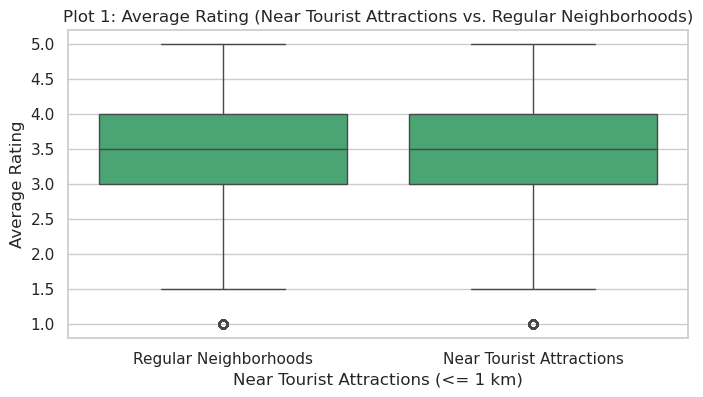

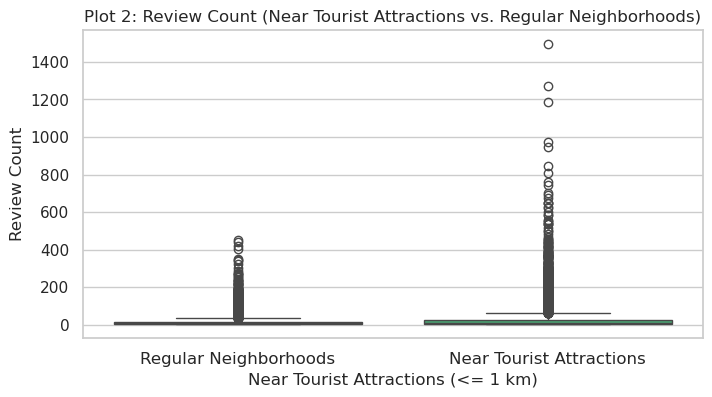

In [68]:
#| echo: false

### SUMMARY STATISTICS AND EXPLORATORY GRAPHS ###

# Convert distance_km to numeric
business_tor_cleaned['distance_km'] = pd.to_numeric(business_tor_cleaned['distance_km'], errors='coerce')

# Drop rows with NaN in distance_km (if any)
business_tor_cleaned = business_tor_cleaned.dropna(subset=['distance_km'])

# Define "near tourist attractions" as businesses within 1 km
near_attractions = business_tor_cleaned[business_tor_cleaned['distance_km'] <= 1]
regular_neighborhoods = business_tor_cleaned[business_tor_cleaned['distance_km'] > 1]

summary_stats = {
    'Metric': ['Average Rating', 'Average Review Count', 'Number of Businesses'],
    'Near Tourist Attractions (<= 1 km)': [
        near_attractions['avg_rating'].mean(),
        near_attractions['review_count'].mean(),
        len(near_attractions)
    ],
    'Regular Neighborhoods (> 1 km)': [
        regular_neighborhoods['avg_rating'].mean(),
        regular_neighborhoods['review_count'].mean(),
        len(regular_neighborhoods)
    ]
}

summary_table = pd.DataFrame(summary_stats)
summary_table['Near Tourist Attractions (<= 1 km)'] = summary_table['Near Tourist Attractions (<= 1 km)'].round(2)
summary_table['Regular Neighborhoods (> 1 km)'] = summary_table['Regular Neighborhoods (> 1 km)'].round(2)

print("Table 1: Businesses Near Tourist Attractions vs. Regular Neighborhoods")
print(summary_table)
print(summary_table)

# Box plot of avg_rating
plt.figure(figsize=(8, 4))
sns.boxplot(x=business_tor_cleaned['distance_km'] <= 1, y=business_tor_cleaned['avg_rating'], color='mediumseagreen')
plt.title('Plot 1: Average Rating (Near Tourist Attractions vs. Regular Neighborhoods)')
plt.xlabel('Near Tourist Attractions (<= 1 km)')
plt.ylabel('Average Rating')
plt.xticks([0, 1], ['Regular Neighborhoods', 'Near Tourist Attractions'])
plt.show()

# Box plot of review_count
plt.figure(figsize=(8, 4))
sns.boxplot(x=business_tor_cleaned['distance_km'] <= 1, y=business_tor_cleaned['review_count'], color='mediumseagreen')
plt.title('Plot 2: Review Count (Near Tourist Attractions vs. Regular Neighborhoods)')
plt.xlabel('Near Tourist Attractions (<= 1 km)', fontsize=12)
plt.ylabel('Review Count', fontsize=12)
plt.xticks([0, 1], ['Regular Neighborhoods', 'Near Tourist Attractions'], fontsize=12)
plt.show()

### 3.2 Business Performance by Attraction Category

Furthermore, businesses near cultural and nature-oriented attractions, such as performing arts, galleries, and parks, generally receive higher ratings and more positive sentiments compared to businesses near transportation hubs and convention centers (Plot 3). Businesses near performing arts have the highest average ratings (approximately 3.7), followed by businesses near galleries and nature/parks (both above 3.5). In contrast, businesses near transportation hubs and convention/trade centers have relatively lower average ratings (around 3.0-3.2). These findings suggest that certain types of attractions may be more conducive to positive customer experiences, possibly due to the relaxing or aesthetically pleasing environments they provide.

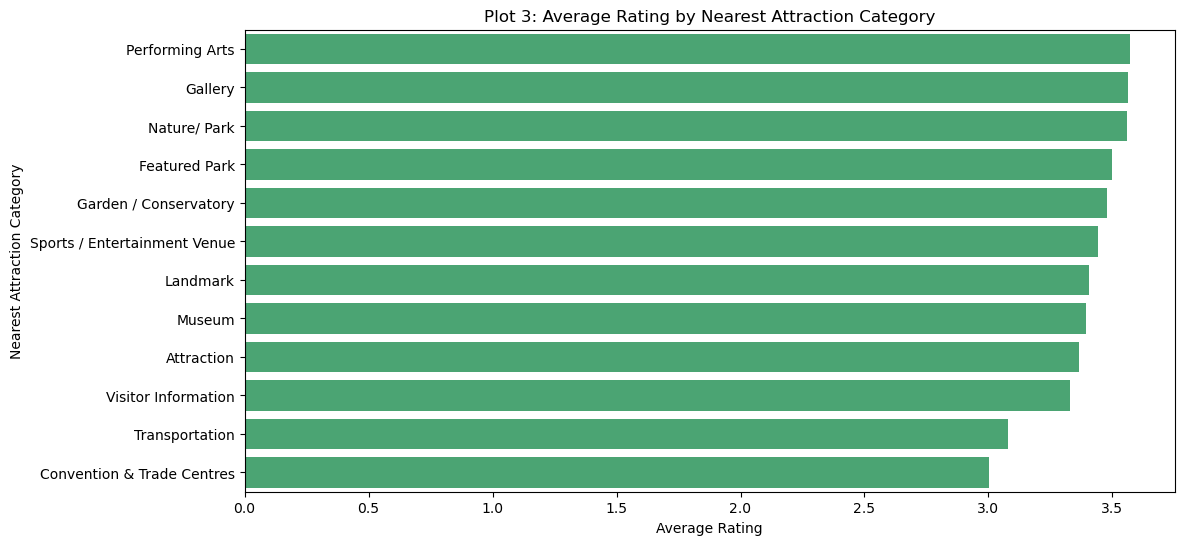

In [29]:
#| echo: false

# Group by nearest_attraction_category, calculate average avg_rating
attraction_rating = business_tor_cleaned.groupby('nearest_attraction_category')['avg_rating'].mean().reset_index()
attraction_rating = attraction_rating.sort_values(by='avg_rating', ascending=False) # sort

# Bar plot 
plt.figure(figsize=(12, 6))
sns.barplot(x='avg_rating', y='nearest_attraction_category', data=attraction_rating, color="mediumseagreen")
plt.title('Plot 3: Average Rating by Nearest Attraction Category', fontsize=12)
plt.xlabel('Average Rating', fontsize=12)
plt.ylabel('Nearest Attraction Category', fontsize=12)
plt.show()

### 3.3 Sentiment Analysis of Reviews

The sentiment analysis of review texts revealed a strongly positive skew in the data. We can see that the majority of reviews express positive sentiment, and the minority is neutral (Plot 4). On Table 1, the exact count confirms this, where we have 373,503 reviews that  express positive sentiment, making up 86.6% of the data we have (illustrated by Plot 5). This distribution shows the general tendency of customers to leave positive reviews on Yelp, whereas 12.1% express negative sentiment, and only 1.3% are neutral reviews.

In [30]:
#| include: false

### SENTIMENT ANALYSIS ###

sia = SentimentIntensityAnalyzer()

def get_sentiment(text):
    return sia.polarity_scores(text)

# Apply sentiment analysis to each review
reviews_tor_final['sentiment'] = reviews_tor_final['review_text'].apply(get_sentiment)

# Extract compound sentiment score
reviews_tor_final['compound_score'] = reviews_tor_final['sentiment'].apply(lambda x: x['compound'])

# Classify sentiment as positive, neutral, or negative
reviews_tor_final['sentiment_label'] = reviews_tor_final['compound_score'].apply(
    lambda score: 'positive' if score > 0.05 else ('negative' if score < -0.05 else 'neutral')
)

# Print sentiment distribution
print(reviews_tor_final['sentiment_label'].value_counts())

sentiment_label
positive    373503
negative     51956
neutral       5447
Name: count, dtype: int64


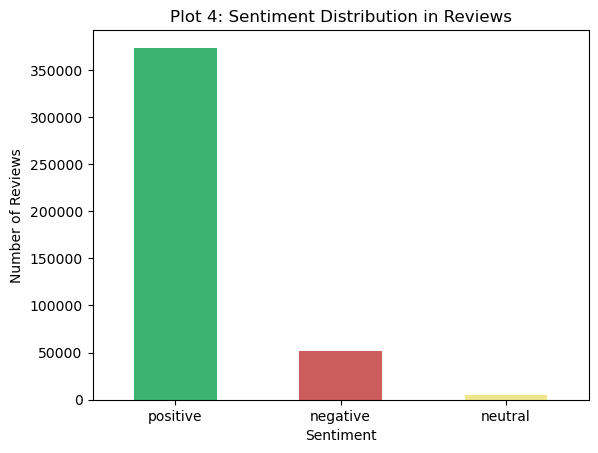

In [31]:
#| echo: FALSE
# Visualize sentiment distribution
sentiment_counts = reviews_tor_final['sentiment_label'].value_counts()
sentiment_counts.plot(kind='bar', color=['mediumseagreen', 'indianred', 'khaki'])
plt.title('Plot 4: Sentiment Distribution in Reviews')
plt.xlabel('Sentiment')
plt.xticks(rotation=0)
plt.ylabel('Number of Reviews')
plt.show()

In [66]:
#| echo: FALSE
# Count the number of positive, neutral, and negative reviews
sentiment_distribution= reviews_tor_final['sentiment_label'].value_counts()

# percentage of each sentiment
sentiment_percentage = reviews_tor_final['sentiment_label'].value_counts(normalize=True) * 100

# summary statistics table
sentiment_summary_vader = pd.DataFrame({
    'Count': sentiment_distribution,
    'Percentage': sentiment_percentage
})

print("Table 1: Sentiment Distribution")
print(sentiment_summary_vader)

Table 1: Sentiment Distribution
                  Count  Percentage
sentiment_label                    
positive         373503   86.678533
negative          51956   12.057386
neutral            5447    1.264081


In [33]:
#| include: FALSE

# See the first few rows with sentiment scores
print(reviews_tor_final[['review_text', 'sentiment', 'compound_score']].head())

                                              review_text  \
329410  My first 1 Star reco-updated 1\/24  \r\n\r\nOr...   
311799  I have booked two trips through Adventure Cent...   
377351  If you're looking for a great view of the Toro...   
38845   Originally an old mill from 1832 located in To...   
250276  This is in Toronto Canada!!\n440 Bloor Street ...   

                                                sentiment  compound_score  
329410  {'neg': 0.045, 'neu': 0.826, 'pos': 0.129, 'co...          0.9481  
311799  {'neg': 0.044, 'neu': 0.854, 'pos': 0.103, 'co...          0.9532  
377351  {'neg': 0.0, 'neu': 0.784, 'pos': 0.216, 'comp...          0.9313  
38845   {'neg': 0.0, 'neu': 0.744, 'pos': 0.256, 'comp...          0.9828  
250276  {'neg': 0.05, 'neu': 0.768, 'pos': 0.182, 'com...          0.9386  


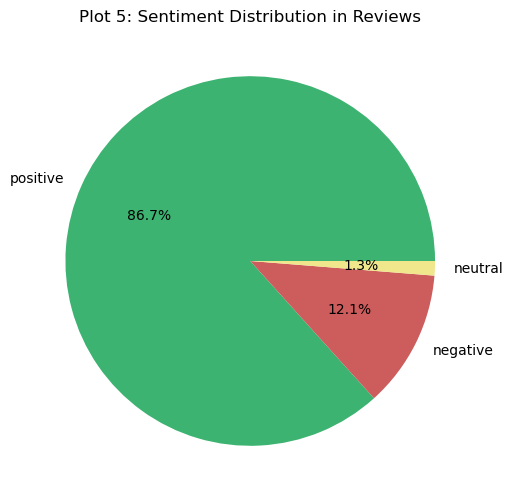

In [34]:
#| echo: false

# Pie chart 
plt.figure(figsize=(8, 6))
reviews_tor_final['sentiment_label'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['mediumseagreen', 'indianred', 'khaki'])
plt.title('Plot 5: Sentiment Distribution in Reviews')
plt.ylabel('')
plt.show()

We also found out that as star ratings increase from 1 to 5, sentiment scores generally become more positive and less variable (as expected, shown on Plot 6). One-star ratings mostly show negative sentiment (median around -0.4), while five-star ratings consistently show high positive sentiment (median above 0.9). Interestingly, even 3-star ratings have a generally positive sentiment median despite being considered "average" ratings, though they have notable negative outliers, so this matched with our finding above that the reviews tend to skew positively. 

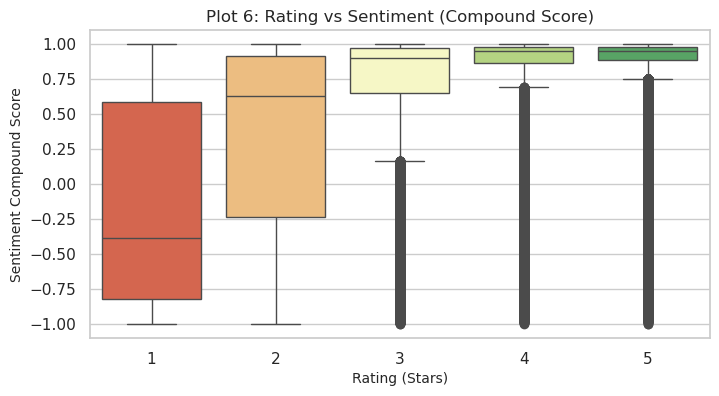

In [69]:
#| echo: false

sns.set(style="whitegrid")

plt.figure(figsize=(8, 4))
sns.boxplot(x='rating', y='compound_score', data=reviews_tor_final, palette="RdYlGn")
plt.title('Plot 6: Rating vs Sentiment (Compound Score)', fontsize=12)
plt.xlabel('Rating (Stars)', fontsize=10)
plt.ylabel('Sentiment Compound Score', fontsize=10)
plt.show()

In [39]:
#| include: FALSE
# Merge reviews with business data
merged_data = pd.merge(
    reviews_tor_final,
    business_tor_cleaned[['business_id', 'nearest_attraction_category', 'distance_km']],
    on='business_id',
    how='left'
)

print(merged_data[['business_id', 'nearest_attraction_category', 'rating', 'sentiment', 'compound_score', 'distance_km']].head())

              business_id nearest_attraction_category  rating  \
0  H5T6WciJ7wVx-JfbZhjwwg                      Museum       1   
1  H5T6WciJ7wVx-JfbZhjwwg                      Museum       4   
2  o8MxZKmLhdrRk8EoRX8Sog                      Museum       3   
3  3HVxkz03TS_ssJ7j3x5dRA                    Landmark       5   
4  fJETfN5aByPwhhwEAtmbJQ             Performing Arts       4   

                                           sentiment  compound_score  \
0  {'neg': 0.045, 'neu': 0.826, 'pos': 0.129, 'co...          0.9481   
1  {'neg': 0.044, 'neu': 0.854, 'pos': 0.103, 'co...          0.9532   
2  {'neg': 0.0, 'neu': 0.784, 'pos': 0.216, 'comp...          0.9313   
3  {'neg': 0.0, 'neu': 0.744, 'pos': 0.256, 'comp...          0.9828   
4  {'neg': 0.05, 'neu': 0.768, 'pos': 0.182, 'com...          0.9386   

   distance_km  
0     2.641902  
1     2.641902  
2     0.170589  
3     0.039949  
4     0.354536  


Businesses with the nearest attractions being cultural venues like performing Arts, galleries, and parks generate the highest sentiment scores for their reviews (with businesses near Performing Arts on average reached almost 0.7 in score), while businesses near transportation facilities and convention/trade centers receive the lowest sentiment scores (around 0.5-0.55). This matched our previous finding of which businesses category have the higher ratings, and our analysis above that generally higher rating produces higher sentiment score (more positive review). However, it is worth mentioing that most attraction categories maintain positive sentiment scores overall, suggesting visitors generally have favorable experiences across business with any attractions nearby. 

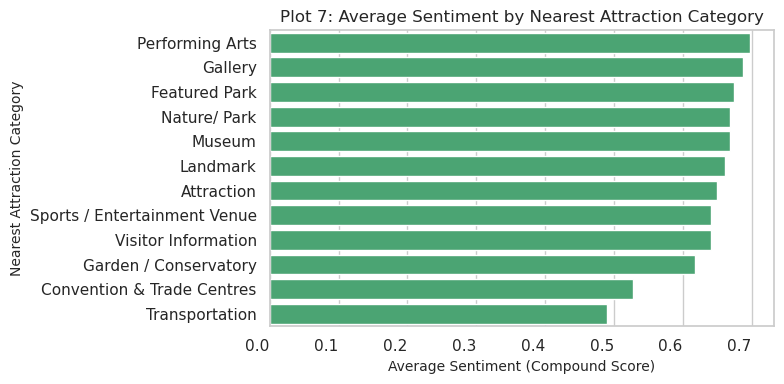

In [70]:
#| echo: false

# Group by nearest_attraction_category, calculate mean sentiment
avg_sentiment_by_category = merged_data.groupby('nearest_attraction_category')['compound_score'].mean().reset_index()

# Sort
avg_sentiment_by_category = avg_sentiment_by_category.sort_values(by='compound_score', ascending=False)

custom_palette = sns.light_palette("seagreen", n_colors=len(attraction_rating))

sns.set(style="whitegrid")
plt.figure(figsize=(8, 4))
sns.barplot(
    x='compound_score',
    y='nearest_attraction_category',
    data=avg_sentiment_by_category,
    color="mediumseagreen"  
)

# bar plot
plt.title('Plot 7: Average Sentiment by Nearest Attraction Category', fontsize=12)
plt.xlabel('Average Sentiment (Compound Score)', fontsize=10)
plt.ylabel('Nearest Attraction Category', fontsize=10)
plt.xticks(ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

Knowing that businesses near attractions generally have positive reviews, we wanted to compare between those which are really closed by the attractions (under or equal to 1 km of distance near the attractions) and those located in regular neighbourhoods. Surprisingly, there is not much of a difference; those in regular neighbourhoods still have on average positive reviews, similar to the really-near attractions ones as shown in Plot 8.

In [44]:
#| include: FALSE
# Drop rows with NaN in distance_km (if any)
merged_data = merged_data.dropna(subset=['distance_km'])

# Define "near tourist attractions" as businesses within 1 km
near_attractions = merged_data[merged_data['distance_km'] <= 1]
regular_neighborhoods = merged_data[merged_data['distance_km'] > 1]

# Calculate average sentiment for each group
avg_sentiment_near = near_attractions['compound_score'].mean()
avg_sentiment_regular = regular_neighborhoods['compound_score'].mean()

# Create a DataFrame for visualization
comparison = pd.DataFrame({
    'Group': ['Near Attractions', 'Regular Neighborhoods'],
    'Average Sentiment': [avg_sentiment_near, avg_sentiment_regular]
})

print("Average Sentiment Comparison:")
print(comparison)

Average Sentiment Comparison:
                   Group  Average Sentiment
0       Near Attractions           0.679413
1  Regular Neighborhoods           0.668155


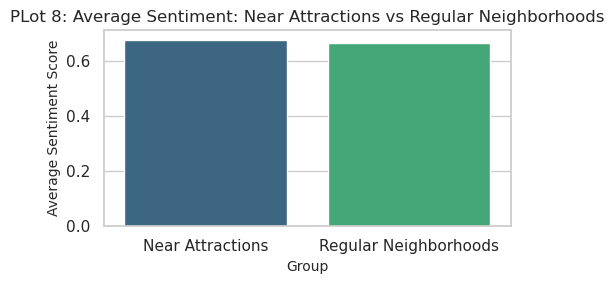

In [60]:
#| echo: FALSE
sns.set(style="whitegrid")
plt.figure(figsize=(5, 3))
sns.barplot(x='Group', y='Average Sentiment', data=comparison, palette='viridis')
plt.title('PLot 8: Average Sentiment: Near Attractions vs Regular Neighborhoods', fontsize=12)
plt.xlabel('Group', fontsize=10)
plt.ylabel('Average Sentiment Score', fontsize=10)
plt.tight_layout()
plt.show()

## 4. Conclusion and Next Step

This analysis has provided several key insights into how tourist attractions influence business performance in Toronto. Businesses near tourist attractionsgenerally receive more reviews, but their ratings are not necessarily higher than those of businesses located further away. Additionally, cultural and nature-oriented attractions appear to be associated with more positive sentiments and higher ratings compared to other types of attractions. Most of the reviews are positive, and they become more positive as the user rating on that review increase.

For the next step in the final project, we plan to implement tokenization, word cloud generation, and Latent Dirichlet Allocation (LDA) topic modeling, to identify common topics in reviews for businesses near different types of attractions. Predictive modeling techniques will also be applied to develop models that predict business success (high ratings, positive sentiment, high amount of reviews) based on location features, including proximity to tourist attractions. This could include regression models to predict ratings or classification models to predict sentiment categories.